In [1]:
import os
import os.path
import tarfile
#import tqdm
import pickle as pkl
import random
import numpy as np
import spacy
import string
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import torch
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## data preprocessing

In [66]:
# read files
cwd = os.getcwd()
path = '/'.join(cwd.split('\\'))+'/'
tar = tarfile.open(path+"aclImdb_v1.tar.gz", "r")
names = tar.getnames()

train_neg_names = [a for a in names if (len(a)>17 and (a[:17]=='aclImdb/train/neg')) ]
train_pos_names = [a for a in names if (len(a)>17 and (a[:17]=='aclImdb/train/pos')) ]
test_neg_names = [a for a in names if (len(a)>16 and (a[:16]=='aclImdb/test/neg')) ]
test_pos_names = [a for a in names if (len(a)>16 and (a[:16]=='aclImdb/test/pos')) ]

#merge files and build labels
train_pos_score = []
for i in train_pos_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            train_pos_score.append(10.0)
        else:
            train_pos_score.append(0)
    else:
        train_pos_score.append(tmp)
        
train_neg_score = []
for i in train_neg_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            train_neg_score.append(10.0)
        else:
            train_neg_score.append(0)
    else:
        train_neg_score.append(tmp)
        
test_pos_score = []
for i in test_pos_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            test_pos_score.append(10.0)
        else:
            test_pos_score.append(0)
    else:
        test_pos_score.append(tmp)
        
test_pos_score = []
for i in test_pos_names:
    tmp = float(i[-5:-4])
    if(tmp == 0):
        if(i[-6] == "1"):
            test_pos_score.append(10.0)
        else:
            test_pos_score.append(0)
    else:
        test_pos_score.append(tmp)
        
train_pos = []
for i in train_pos_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    train_pos.append(a.read())
    a.close()
    os.remove(path+i)
    
train_neg = []
for i in train_neg_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    train_neg.append(a.read())
    a.close()
    os.remove(path+i)

test_pos = []
for i in test_pos_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    test_pos.append(a.read())
    a.close()
    os.remove(path+i)
    
test_neg = []
for i in test_neg_names:
    tar.extract(i, path = path)
    a=open(path+i,'r',encoding = "utf-8")
    test_neg.append(a.read())
    a.close()
    os.remove(path+i)

train_label = [1] * len(train_pos) +[0] * len(train_neg)
train = train_pos + train_neg
label_test = [1] * len(test_pos) +[0] * len(test_neg)
data_test = test_pos + test_neg
train_score = train_pos_score + train_neg_score
score_test = test_pos_score +test_neg_score

# split training/validation sets
val_index = random.sample(range(len(train)), 5000)
train_index = list(set(range(len(train))) - set(val_index))
data_val = np.array(train)[val_index]
label_val = np.array(train_label)[val_index]
data_train = np.array(train)[train_index]
label_train = np.array(train_label)[train_index]
score_val = np.array(train_score)[val_index]
score_train = np.array(train_score)[train_index]

In [3]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens]

In [4]:
def tokenize_dataset(dataset, n_gram=1, punctuation=True, stop_word=True):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(str(sample))
        if(stop_word):
            tokens_filter = [token for token in tokens if ((token not in punctuations) and (token not in STOP_WORDS))]
        elif(punctuation):
            tokens_filter = [token for token in tokens if (token not in punctuations)]
        else:
            tokens_filter = tokens
        all_tokens += tokens_filter
        tokens_num = len(tokens)
        for k in range(1,4):
            if(n_gram > k):
                for i in range(0, tokens_num-k):
                    tokens_filter.append(" ".join(tokens[i:(i+k+1)]))
                    all_tokens += [" ".join(tokens[i:(i+k+1)])]
        token_dataset.append(tokens_filter)
    return token_dataset, all_tokens

In [626]:
#tokenization
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(data_val, 2) #change n_gram, punctuation and stop_word for different tokenization scheme
pkl.dump(val_data_tokens, open("val_data_tokens_2gram_hw1.p", "wb"))

print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(data_train, 2)
pkl.dump(train_data_tokens, open("train_data_tokens_2gram_hw1.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_2gram_hw1.p", "wb"))

print("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(data_test, 2)
pkl.dump(test_data_tokens, open("test_data_tokens_2gram_hw1.p", "wb"))

Tokenizing val data
Tokenizing train data
Tokenizing test data


In [4]:
#check size of tokened files
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 7720323


In [6]:
max_vocab_size = 10000 # tuning parameter
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

#token2id, id2token = build_vocab(all_train_tokens)

In [7]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

#train_data_indices = token2index_dataset(train_data_tokens)
#val_data_indices = token2index_dataset(val_data_tokens)
#test_data_indices = token2index_dataset(test_data_tokens)

# double checking
#print ("Train dataset size is {}".format(len(train_data_indices)))
#print ("Val dataset size is {}".format(len(val_data_indices)))
#print ("Test dataset size is {}".format(len(test_data_indices)))

## Predicting Sentiment

In [8]:
MAX_SENTENCE_LENGTH = 600

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).long(), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, 2)
        #self.dropout = nn.Dropout(p=1 - nodropout_probability)
        #self.linear2 = nn.Linear(200, 2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear1(out)
        #out = F.softmax(out, dim=1)
        #out = self.dropout(out)
        #out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out



In [10]:
#set hyperparameters
emb_dim = 200
learning_rate = 0.001
num_epochs = 20
nodropout_probability = 0.8
#model = BagOfWords(len(id2token), emb_dim).to(device)

In [11]:
def do_train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0
    for data, lengths, labels in dataloader:
        optimizer.zero_grad()
        y_hat = model(data.to(device), lengths.to(device))
        loss = criterion(y_hat.cpu(), labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data) / len(dataloader.dataset)
    return train_loss

def do_eval(model, dataloader):
    model.eval()
    y_ls = []
    y_hat_ls = []
    val_loss = 0
    with torch.no_grad():
        for data, lengths, labels in dataloader:
            y_hat = model(data.to(device), lengths.to(device))
            loss = criterion(y_hat.cpu(), labels.long())
            y_hat_ls.append(y_hat.cpu())
            y_ls.append(labels)
            val_loss += loss.item() * len(data) / len(dataloader.dataset)
    optimizer.zero_grad()
    return val_loss, torch.cat(y_hat_ls, dim=0), torch.cat(y_ls, dim=0)

def acc(model, dataloader):
    val_loss, pred,true = do_eval(
    model = model,
    dataloader = dataloader,
    )
    return val_loss, (torch.exp(pred).max(1)[1] == true).float().mean().item()

### tokenization scheme

remove nothing
Epoch: [1/15], Train Loss: 0.5976500963419676, Val Loss: 0.48610473543405525, Val Acc: 0.7906000018119812
Epoch: [2/15], Train Loss: 0.3991314376890662, Val Loss: 0.3617242619395257, Val Acc: 0.8461999893188477
Epoch: [3/15], Train Loss: 0.3085507886856796, Val Loss: 0.31741798177361497, Val Acc: 0.8655999898910522
Epoch: [4/15], Train Loss: 0.26120887722820024, Val Loss: 0.29772660449147226, Val Acc: 0.8697999715805054
Epoch: [5/15], Train Loss: 0.22947909733280553, Val Loss: 0.28658779546618457, Val Acc: 0.8736000061035156
Epoch: [6/15], Train Loss: 0.20543330941349242, Val Loss: 0.2842197573930025, Val Acc: 0.8777999877929688
Epoch: [7/15], Train Loss: 0.18597799362614748, Val Loss: 0.2907815743237734, Val Acc: 0.8787999749183655
Epoch: [8/15], Train Loss: 0.16893409070558835, Val Loss: 0.28532591395080087, Val Acc: 0.8795999884605408
Epoch: [9/15], Train Loss: 0.15389020480215548, Val Loss: 0.2910742562264205, Val Acc: 0.8794000148773193
Epoch: [10/15], Train Loss: 0

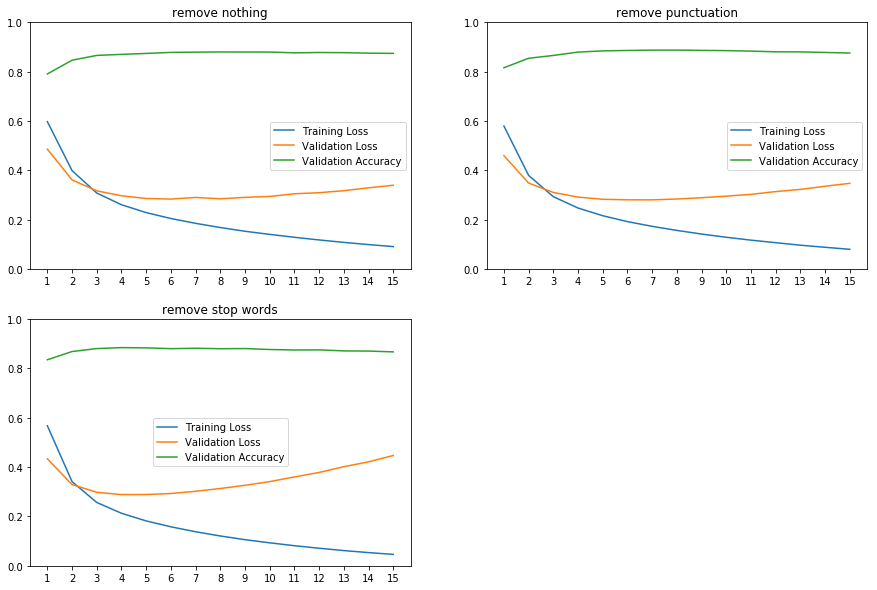

In [19]:

loss_train_t = []
loss_val_t = []
acc_val_t = []
for tok in [1, 2, 3]:
    if(tok == 1):
        print("do nothing")
        #tokenization
        #print ("Tokenizing val data")
        val_data_tokens, _ = tokenize_dataset(data_val, 1, False, False) #change n_gram, punctuation and stop_word for different tokenization scheme
        #print ("Tokenizing train data")
        train_data_tokens, all_train_tokens = tokenize_dataset(data_train, 1, False, False)
    elif(tok == 2):
        print("remove punctuations")
        #tokenization
        #print ("Tokenizing val data")
        val_data_tokens, _ = tokenize_dataset(data_val, 1, True, False) #change n_gram, punctuation and stop_word for different tokenization scheme
        #print ("Tokenizing train data")
        train_data_tokens, all_train_tokens = tokenize_dataset(data_train, 1, True, False)
    
    elif(tok == 3):
        print("remove stop words")
        #tokenization
        #print ("Tokenizing val data")
        val_data_tokens, _ = tokenize_dataset(data_val, 1 ) #change n_gram, punctuation and stop_word for different tokenization scheme
        #print ("Tokenizing train data")
        train_data_tokens, all_train_tokens = tokenize_dataset(data_train, 1)
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    BATCH_SIZE = 50
    train_dataset = NewsGroupDataset(train_data_indices, label_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, label_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
    
    learning_rate = 0.001
    num_epochs = 15
    nodropout_probability = 0.8
    max_vocab_size = 10000
    MAX_SENTENCE_LENGTH = 300 
    emb_dim = 200
    
    model = BagOfWords(len(id2token), emb_dim).to(device)
    #lambda1 = lambda epoch: 1-0.1*epoch
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("remove nothing")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("remove punctuations")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("remove punctuations and stopwords")

plt.savefig("token.pdf")
plt.show()

### n-gram

1.gram
Epoch: [1/15], Train Loss: 0.5666385818272827, Val Loss: 0.4328964111208914, Val Acc: 0.8338000178337097
Epoch: [2/15], Train Loss: 0.34053077466785886, Val Loss: 0.3288179591298104, Val Acc: 0.8672000169754028
Epoch: [3/15], Train Loss: 0.25628396635875117, Val Loss: 0.2975736938416957, Val Acc: 0.8791999816894531
Epoch: [4/15], Train Loss: 0.2126263870857656, Val Loss: 0.28805502645671366, Val Acc: 0.8830000162124634
Epoch: [5/15], Train Loss: 0.181561632398516, Val Loss: 0.28845467150211335, Val Acc: 0.8820000290870667
Epoch: [6/15], Train Loss: 0.15780125478282556, Val Loss: 0.2925266705453396, Val Acc: 0.8787999749183655
Epoch: [7/15], Train Loss: 0.13779407406225802, Val Loss: 0.3015570622682573, Val Acc: 0.8804000020027161
Epoch: [8/15], Train Loss: 0.12072114744223646, Val Loss: 0.31281176395714266, Val Acc: 0.878600001335144
Epoch: [9/15], Train Loss: 0.10586963323876251, Val Loss: 0.32576208494603665, Val Acc: 0.8791999816894531
Epoch: [10/15], Train Loss: 0.0929708239

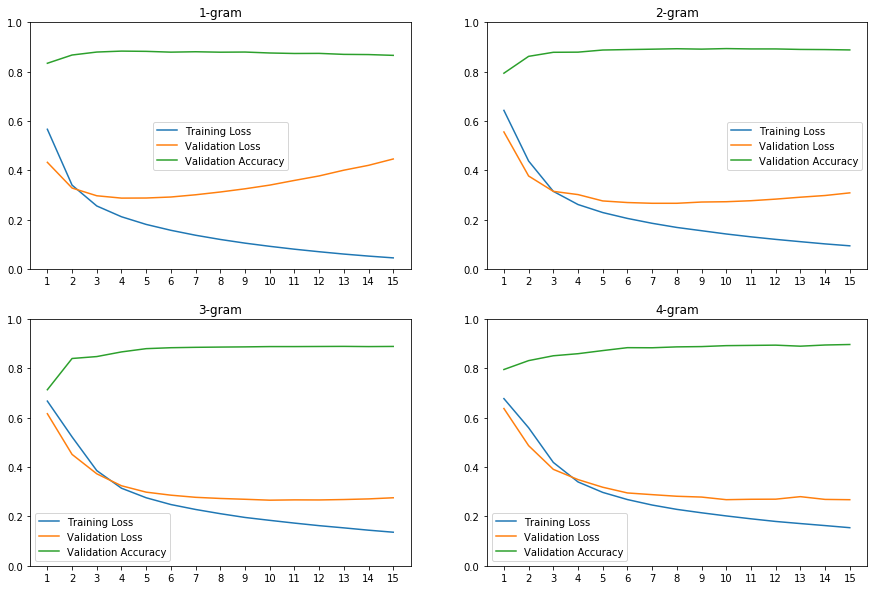

In [28]:
loss_train_t = []
loss_val_t = []
acc_val_t = []
for gram in [1, 2, 3, 4]:
    print("{}.gram".format(gram))
    #tokenization
    #print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    """
    if(gram==1):
        val_data_tokens = pkl.load(open("val_data_tokens_hw1.p", "rb"))
        train_data_tokens = pkl.load(open("train_data_tokens_hw1.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens_hw1.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens_hw1.p", "rb"))
    elif(gram==2):
        val_data_tokens = pkl.load(open("val_data_tokens_2gram_hw1.p", "rb"))
        train_data_tokens = pkl.load(open("train_data_tokens_2gram_hw1.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens_2gram_hw1.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens_2gram_hw1.p", "rb"))
    elif(gram==3):
        val_data_tokens = pkl.load(open("val_data_tokens_3gram_hw1.p", "rb"))
        train_data_tokens = pkl.load(open("train_data_tokens_3gram_hw1.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens_3gram_hw1.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens_3gram_hw1.p", "rb"))
    elif(gram==4):
        val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
        train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens_4gram_hw1.p", "rb"))
    """
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    BATCH_SIZE = 50
    train_dataset = NewsGroupDataset(train_data_indices, label_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, label_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
    
    learning_rate = 0.001
    num_epochs = 15
    nodropout_probability = 0.8
    max_vocab_size = 10000
    MAX_SENTENCE_LENGTH = 300 * gram
    emb_dim = 200
    
    model = BagOfWords(len(id2token), emb_dim).to(device)
    #lambda1 = lambda epoch: 1-0.1*epoch
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("1-gram")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("2-gram")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("3-gram")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[3], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("4-gram")
plt.savefig("ngram.pdf")
plt.show()

### vocabulary size

voc = 10000
Epoch: [1/15], Train Loss: 0.6809685103595258, Val Loss: 0.6491730403900147, Val Acc: 0.7038000226020813
Epoch: [2/15], Train Loss: 0.5806093692034485, Val Loss: 0.5131932258605958, Val Acc: 0.8271999955177307
Epoch: [3/15], Train Loss: 0.44665649086236975, Val Loss: 0.4158727672696114, Val Acc: 0.8353999853134155
Epoch: [4/15], Train Loss: 0.36000014692544946, Val Loss: 0.3542289540171624, Val Acc: 0.8626000285148621
Epoch: [5/15], Train Loss: 0.31188764747232206, Val Loss: 0.32544026136398324, Val Acc: 0.8672000169754028
Epoch: [6/15], Train Loss: 0.27947130747139437, Val Loss: 0.30181303605437293, Val Acc: 0.8784000277519226
Epoch: [7/15], Train Loss: 0.25641949474811554, Val Loss: 0.28886956095695515, Val Acc: 0.8858000040054321
Epoch: [8/15], Train Loss: 0.23793937249109157, Val Loss: 0.2817713537812234, Val Acc: 0.8866000175476074
Epoch: [9/15], Train Loss: 0.22398276653140786, Val Loss: 0.27363118819892407, Val Acc: 0.8876000046730042
Epoch: [10/15], Train Loss: 0.20

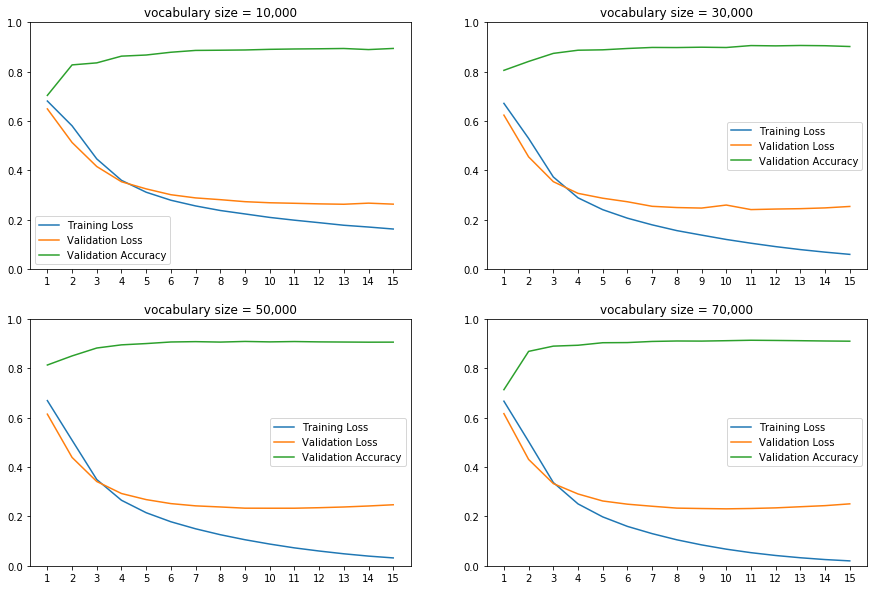

In [29]:
loss_train_t = []
loss_val_t = []
acc_val_t = []
val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
BATCH_SIZE = 50
for voc in [10000, 30000, 50000, 70000]:
    print("voc = {}".format(voc))
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    
    learning_rate = 0.001
    num_epochs = 15 
    nodropout_probability = 0.8
    max_vocab_size = voc
    MAX_SENTENCE_LENGTH = 1200
    emb_dim = 200
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_dataset = NewsGroupDataset(train_data_indices, label_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, label_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
    
    model = BagOfWords(len(id2token), emb_dim).to(device)
    #lambda1 = lambda epoch: 1-0.1*epoch
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 10,000")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 30,000")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 50,000")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[3], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 70,000")
plt.savefig("voc.pdf")
plt.show()

voc = 90000
Epoch: [1/15], Train Loss: 0.6681756220757956, Val Loss: 0.6076966923475265, Val Acc: 0.8163999915122986
Epoch: [2/15], Train Loss: 0.4908501566201452, Val Loss: 0.41405669301748266, Val Acc: 0.8664000034332275
Epoch: [3/15], Train Loss: 0.3187005715072155, Val Loss: 0.3217398290336133, Val Acc: 0.8924000263214111
Epoch: [4/15], Train Loss: 0.23138646727427867, Val Loss: 0.27523352310061466, Val Acc: 0.897599995136261
Epoch: [5/15], Train Loss: 0.17753479868173586, Val Loss: 0.25169428654015064, Val Acc: 0.9053999781608582
Epoch: [6/15], Train Loss: 0.13869633257389077, Val Loss: 0.23965589247643945, Val Acc: 0.9075999855995178
Epoch: [7/15], Train Loss: 0.1096821948233992, Val Loss: 0.23029937580227858, Val Acc: 0.9115999937057495
Epoch: [8/15], Train Loss: 0.08478357831016187, Val Loss: 0.22658978968858723, Val Acc: 0.9146000146865845
Epoch: [9/15], Train Loss: 0.06535226362291723, Val Loss: 0.22422577150166031, Val Acc: 0.9143999814987183
Epoch: [10/15], Train Loss: 0.04

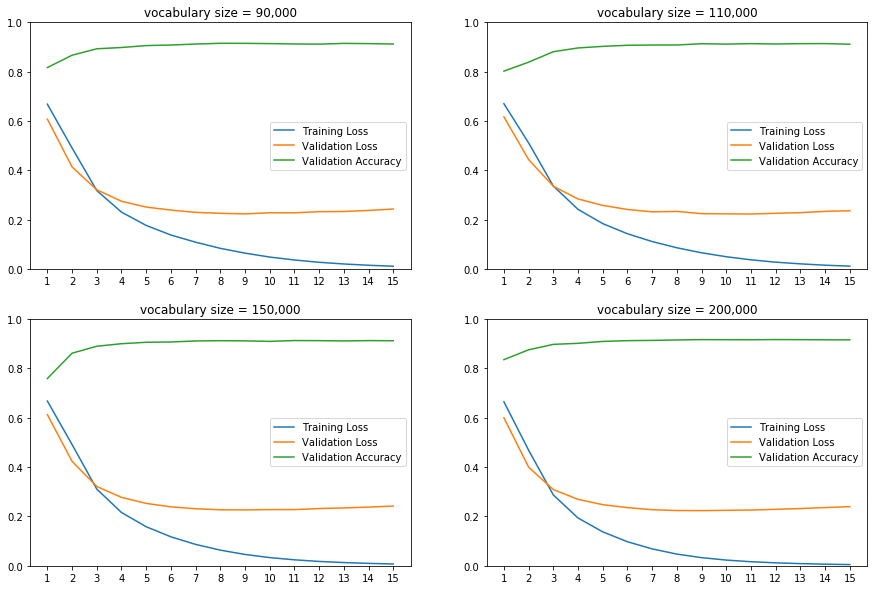

In [11]:
loss_train_t = []
loss_val_t = []
acc_val_t = []
#val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
#train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
BATCH_SIZE = 50
for voc in [90000, 110000, 150000, 200000]:
    print("voc = {}".format(voc))
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    
    learning_rate = 0.001
    num_epochs = 15 
    nodropout_probability = 0.8
    max_vocab_size = voc
    MAX_SENTENCE_LENGTH = 1200
    emb_dim = 200
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_dataset = NewsGroupDataset(train_data_indices, label_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, label_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
    
    model = BagOfWords(len(id2token), emb_dim).to(device)
    #lambda1 = lambda epoch: 1-0.1*epoch
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 90,000")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 110,000")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 150,000")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[3], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("vocabulary size = 200,000")
plt.savefig("voc2.pdf")
plt.show()

### embedding size

In [ ]:
loss_train_t = []
loss_val_t = []
acc_val_t = []
#val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
#train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
for emb in [200, 400, 600, 800]:
    print("emb = {}".format(emb))
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    
    learning_rate = 0.001
    num_epochs = 20
    nodropout_probability = 0.8
    
    
    emb_dim = emb
    

    
    model = BagOfWords(len(id2token), emb_dim).to(device)
    #lambda1 = lambda epoch: 1-0.1*epoch
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

emb = 200
Epoch: [1/20], Train Loss: 0.6621664890646931, Val Loss: 0.5915550285577771, Val Acc: 0.821399986743927
Epoch: [2/20], Train Loss: 0.4568830558657645, Val Loss: 0.39371189862489697, Val Acc: 0.8736000061035156
Epoch: [3/20], Train Loss: 0.27762538470327897, Val Loss: 0.30233563482761383, Val Acc: 0.8924000263214111
Epoch: [4/20], Train Loss: 0.18602374566718946, Val Loss: 0.26247024476528164, Val Acc: 0.8992000222206116
Epoch: [5/20], Train Loss: 0.12937051213346418, Val Loss: 0.24177379496395596, Val Acc: 0.9052000045776367
Epoch: [6/20], Train Loss: 0.09061972036026425, Val Loss: 0.23140888698399065, Val Acc: 0.9083999991416931
Epoch: [7/20], Train Loss: 0.06207202021963895, Val Loss: 0.2260564258694649, Val Acc: 0.9085999727249146
Epoch: [8/20], Train Loss: 0.04263272754848007, Val Loss: 0.22310435362160205, Val Acc: 0.9083999991416931
Epoch: [9/20], Train Loss: 0.029218274476006615, Val Loss: 0.22099104307591924, Val Acc: 0.9107999801635742
Epoch: [10/20], Train Loss: 0.0

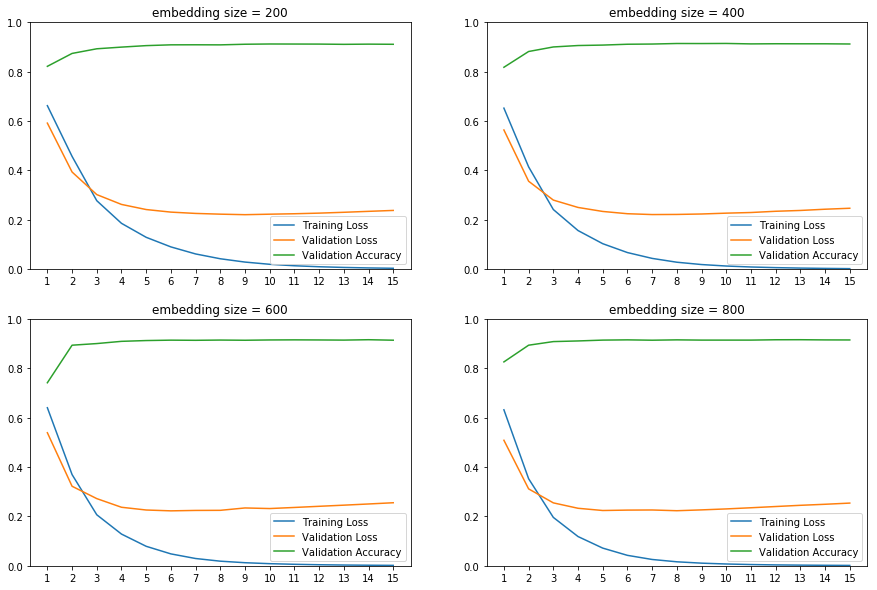

In [15]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("embedding size = 200")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("embedding size = 400")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("embedding size = 600")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[3], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("embedding size = 800")
plt.savefig("embedding.pdf")
plt.show()

### optimization algorithm

In [30]:
loss_train_t = [loss_train_t[3]]
loss_val_t = [loss_val_t[3]]
acc_val_t = [acc_val_t[3]]
#val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
#train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
emb_dim = 800
for alg in [1]:
   
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    if(alg == 1):
        print("SGD")
        learning_rate = 0.2
        num_epochs = 15   
        model = BagOfWords(len(id2token), emb_dim).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = torch.nn.NLLLoss()
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

SGD
Epoch: [1/300], Train Loss: 1.4019624285399905, Val Loss: 0.6817729038000105, Val Acc: 0.5568000078201294
Epoch: [2/300], Train Loss: 0.7193489798903455, Val Loss: 0.6703700417280195, Val Acc: 0.5392000079154968
Epoch: [3/300], Train Loss: 0.6851149976253506, Val Loss: 0.6487790745496753, Val Acc: 0.6204000115394592
Epoch: [4/300], Train Loss: 0.661618705838919, Val Loss: 0.6352645099163055, Val Acc: 0.6692000031471252
Epoch: [5/300], Train Loss: 0.6538205114006992, Val Loss: 0.6494210141897201, Val Acc: 0.5899999737739563
Epoch: [6/300], Train Loss: 0.6483817058801646, Val Loss: 0.6574630981683732, Val Acc: 0.5753999948501587
Epoch: [7/300], Train Loss: 0.6418978612869976, Val Loss: 0.7262445545196534, Val Acc: 0.5249999761581421
Epoch: [8/300], Train Loss: 0.6308783052861696, Val Loss: 0.6137240892648698, Val Acc: 0.6668000221252441
Epoch: [9/300], Train Loss: 0.6270299743860958, Val Loss: 0.6313972085714342, Val Acc: 0.6230000257492065
Epoch: [10/300], Train Loss: 0.622978791743

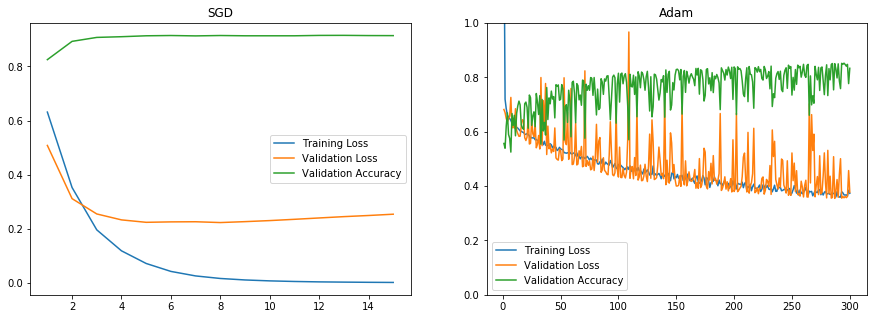

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
#plt.xticks(range(1, len(loss_val_t[0])+1))
#plt.ylim(0, 1)
plt.legend()
plt.title("SGD")

plt.subplot(122)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
#plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("Adam")
plt.savefig("optimization.pdf")
plt.show()

### learning rate

In [15]:
loss_train_t = [loss_train_t[3]]
loss_val_t = [loss_val_t[3]]
acc_val_t = [acc_val_t[3]]
#val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
#train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
emb_dim = 800
for lr in [0.01, 0.0001]:
   
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    if(lr == 0.01):
        print("lr = 0.01")
        learning_rate = 0.01
        num_epochs = 15   
        model = BagOfWords(len(id2token), emb_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif(lr == 0.0001):
        print("lr = 0.0001")
        learning_rate = 0.0001
        num_epochs = 40  
        model = BagOfWords(len(id2token), emb_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.NLLLoss()
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

lr = 0.01
Epoch: [1/15], Train Loss: 0.37291765650734277, Val Loss: 0.29441224694252005, Val Acc: 0.8726000189781189
Epoch: [2/15], Train Loss: 0.04985738575225695, Val Loss: 0.24841653332114227, Val Acc: 0.9088000059127808
Epoch: [3/15], Train Loss: 0.0047823915047047185, Val Loss: 0.29187889602035305, Val Acc: 0.8989999890327454
Epoch: [4/15], Train Loss: 0.0015990419830632142, Val Loss: 0.27134553112089643, Val Acc: 0.9106000065803528
Epoch: [5/15], Train Loss: 0.0008214904966735042, Val Loss: 0.2816970155760646, Val Acc: 0.9125999808311462
Epoch: [6/15], Train Loss: 0.00043560284404520644, Val Loss: 0.28973962649703033, Val Acc: 0.9124000072479248
Epoch: [7/15], Train Loss: 0.00029570453176347634, Val Loss: 0.29693613201379787, Val Acc: 0.9133999943733215
Epoch: [8/15], Train Loss: 0.00021015622614868333, Val Loss: 0.30378905769437553, Val Acc: 0.9125999808311462
Epoch: [9/15], Train Loss: 0.00015381140701720126, Val Loss: 0.3102325055375696, Val Acc: 0.9139999747276306
Epoch: [10/

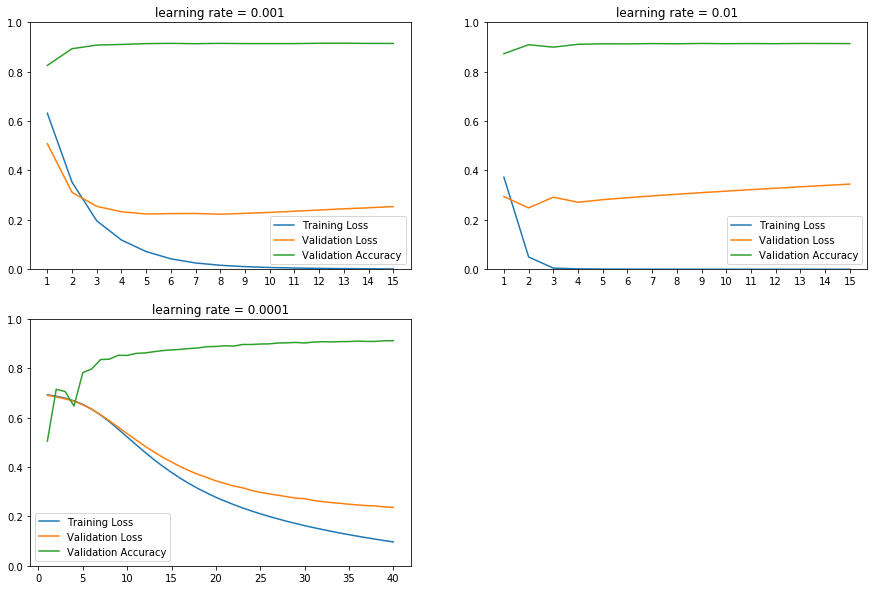

In [28]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("learning rate = 0.001")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("learning rate = 0.01")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
#plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("learning rate = 0.0001")
plt.savefig("lr.pdf")
plt.show()

In [14]:
loss_train_t = [loss_train_t[1]]
loss_val_t = [loss_val_t[1]]
acc_val_t = [acc_val_t[1]]
#val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
#train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
emb_dim = 800
for lr in [1, 2]:
   
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    if(lr == 1):
        print("lr = 0.001-0.00005*epoch")
        learning_rate = 0.01
        num_epochs = 15   
        model = BagOfWords(len(id2token), emb_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        lambda1 = lambda epoch: 1-0.05*epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    elif(lr == 2):
        print("lr = 0.001-0.0001*epoch")
        learning_rate = 0.001
        num_epochs = 10   
        model = BagOfWords(len(id2token), emb_dim).to(device)
        optimizer = torch.optim.Adan(model.parameters(), lr=learning_rate)
        lambda1 = lambda epoch: 1-0.1*epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    criterion = torch.nn.NLLLoss()
    loss_train = []
    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

lr = 0.001-0.00005*epoch
Epoch: [1/15], Train Loss: 0.38024803051725026, Val Loss: 0.2513610998541117, Val Acc: 0.9003999829292297
Epoch: [2/15], Train Loss: 0.04908180026686751, Val Loss: 0.24279294688254588, Val Acc: 0.9093999862670898
Epoch: [3/15], Train Loss: 0.004696977569547013, Val Loss: 0.25414937376976, Val Acc: 0.9110000133514404
Epoch: [4/15], Train Loss: 0.001390460668990273, Val Loss: 0.26929625380784267, Val Acc: 0.9110000133514404
Epoch: [5/15], Train Loss: 0.0007777359850661008, Val Loss: 0.275036144517362, Val Acc: 0.9120000004768372
Epoch: [6/15], Train Loss: 0.0004981077320917394, Val Loss: 0.28308258742094056, Val Acc: 0.9107999801635742
Epoch: [7/15], Train Loss: 0.0003505148998010556, Val Loss: 0.28952989511191846, Val Acc: 0.9125999808311462
Epoch: [8/15], Train Loss: 0.0002594768646667944, Val Loss: 0.29542330056428906, Val Acc: 0.9124000072479248
Epoch: [9/15], Train Loss: 0.00019915694007067948, Val Loss: 0.3007978679426013, Val Acc: 0.9136000275611877
Epoch:

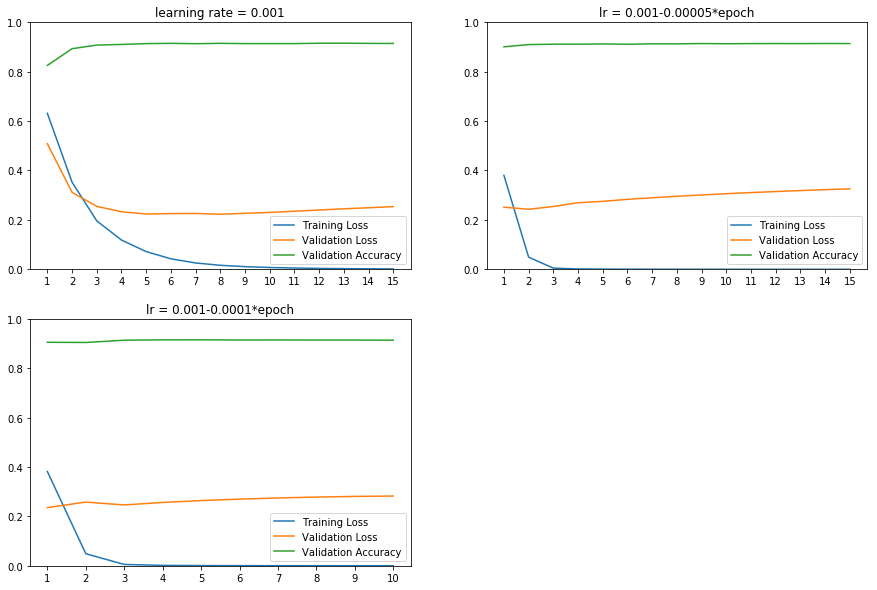

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("learning rate = 0.001")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("lr = 0.001-0.00005*epoch")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("lr = 0.001-0.0001*epoch")
plt.savefig("lar.pdf")
plt.show()

### network structure - activation function

In [23]:
class BagOfWords_hidden(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim, nodropout_probability, activate):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        @nodroupout_probability: probability of not dropout
        @activate: activation function of the hidden layer
        """
        super(BagOfWords_hidden, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, 100)
        self.dropout = nn.Dropout(p=1 - nodropout_probability)
        self.linear2 = nn.Linear(100, 2)
        self.activate = activate
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear1(out)
        #out = F.softmax(out, dim=1)
        out = self.activate(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

loss_train_t = []
loss_val_t = []
acc_val_t = []
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
emb_dim = 800
for activation in [torch.sigmoid, torch.tanh, F.relu]:
   
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    criterion = torch.nn.NLLLoss()
    loss_train = []
    loss_val = []
    acc_val = []
    learning_rate = 0.001
    num_epochs = 15 
    model = BagOfWords_hidden(len(id2token), emb_dim, 1, activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

Epoch: [1/15], Train Loss: 0.690106614679098, Val Loss: 0.626011323928833, Val Acc: 0.8059999942779541
Epoch: [2/15], Train Loss: 0.3828876471146939, Val Loss: 0.27762973010540004, Val Acc: 0.8894000053405762
Epoch: [3/15], Train Loss: 0.1723651350382715, Val Loss: 0.2525896871834993, Val Acc: 0.896399974822998
Epoch: [4/15], Train Loss: 0.0860874003055505, Val Loss: 0.2795747555047273, Val Acc: 0.8939999938011169
Epoch: [5/15], Train Loss: 0.03751863078156021, Val Loss: 0.2692191199585795, Val Acc: 0.9097999930381775
Epoch: [6/15], Train Loss: 0.01648898939223727, Val Loss: 0.34306657508015637, Val Acc: 0.8944000005722046
Epoch: [7/15], Train Loss: 0.009279751909780325, Val Loss: 0.3079740965925157, Val Acc: 0.9111999869346619
Epoch: [8/15], Train Loss: 0.00518717616294453, Val Loss: 0.3242900215089322, Val Acc: 0.9106000065803528
Epoch: [9/15], Train Loss: 0.0039037027525046127, Val Loss: 0.34048043722286825, Val Acc: 0.9088000059127808
Epoch: [10/15], Train Loss: 0.00298261617002936

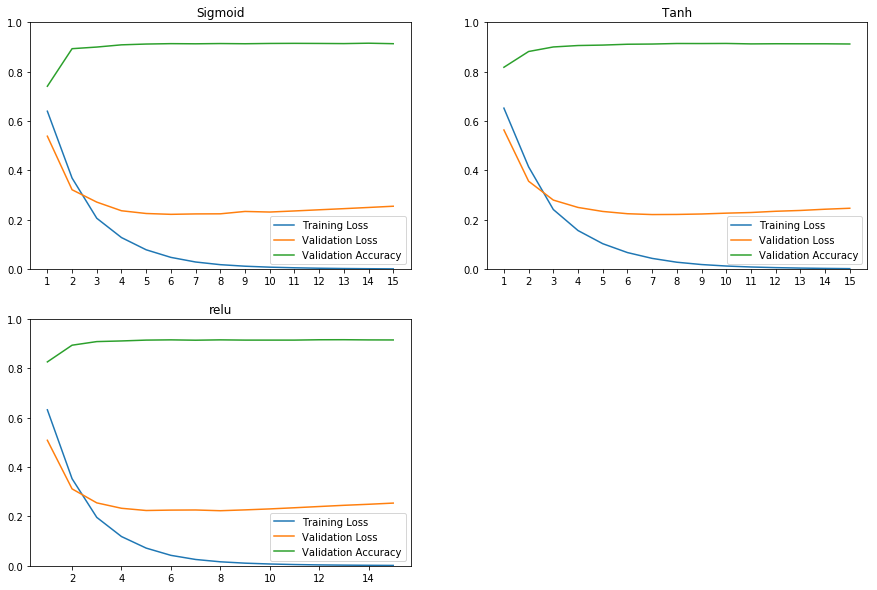

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("Sigmoid")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("Tanh")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
#plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("relu")
plt.savefig("HW1/image/hidden.pdf")
plt.show()

### network structure - dropout probability

In [18]:
loss_train_t = []
loss_val_t = []
acc_val_t = []
#val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
#train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
emb_dim = 800
for npdrop in [0.5, 0.6, 0.7, 0.8]:
   
    #tokenization
    #print ("Tokenizing val data")
    #val_data_tokens, _ = tokenize_dataset(data_val, gram) #change n_gram, punctuation and stop_word for different tokenization scheme
    #print ("Tokenizing train data")
    #train_data_tokens, all_train_tokens = tokenize_dataset(data_train, gram)
    #print("Tokenizing test data")
    #test_data_tokens, _ = tokenize_dataset(data_test, gram)
    criterion = torch.nn.NLLLoss()
    loss_train = []
    loss_val = []
    acc_val = []
    learning_rate = 0.001
    num_epochs = 20 
    model = BagOfWords_hidden(len(id2token), emb_dim, npdrop, F.sigmoid).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        loss_train.append(loss)
        val_loss, val_acc = acc(model, val_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)

Epoch: [1/15], Train Loss: 0.5711405391991135, Val Loss: 0.36803005889058123, Val Acc: 0.8670000123977661
Epoch: [2/15], Train Loss: 0.3176949445903301, Val Loss: 0.29171348109841346, Val Acc: 0.903199999332428
Epoch: [3/15], Train Loss: 0.24891395136713948, Val Loss: 0.2866655401140453, Val Acc: 0.9063999938964844
Epoch: [4/15], Train Loss: 0.20642950072884564, Val Loss: 0.2796253753453493, Val Acc: 0.9099999952316284
Epoch: [5/15], Train Loss: 0.1717395784985274, Val Loss: 0.2947921790927648, Val Acc: 0.9095999884605408
Epoch: [6/15], Train Loss: 0.14839730495587014, Val Loss: 0.3137598827481274, Val Acc: 0.9055999803543091
Epoch: [7/15], Train Loss: 0.12265012345975272, Val Loss: 0.3448862634599216, Val Acc: 0.9070000128746033
Epoch: [8/15], Train Loss: 0.10453894305508588, Val Loss: 0.3828127862513065, Val Acc: 0.9127999925613403
Epoch: [9/15], Train Loss: 0.08825534498784686, Val Loss: 0.4454769583046435, Val Acc: 0.9084000196456909
Epoch: [10/15], Train Loss: 0.07288363884901626,

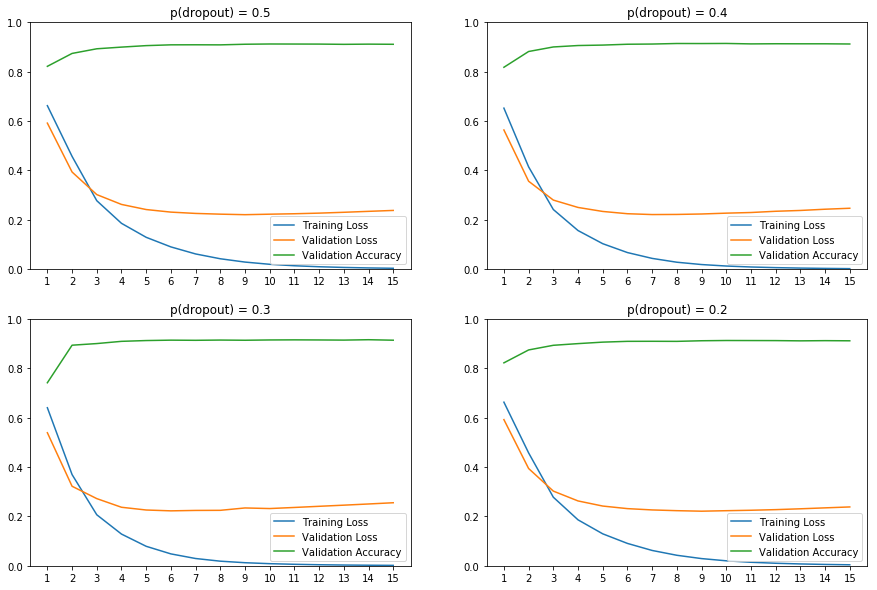

In [16]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("p(dropout) = 0.5")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[1])+1), acc_val_t[1], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("p(dropout) = 0.4")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[2])+1), acc_val_t[2], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("p(dropout) = 0.3")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.plot(range(1, len(loss_val_t[0])+1), acc_val_t[0], label="Validation Accuracy")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("p(dropout) = 0.2")

plt.savefig("HW1/image/dropout.pdf")
plt.show()


### final model

In [21]:
#early stopping
val_data_tokens = pkl.load(open("val_data_tokens_4gram_hw1.p", "rb"))
train_data_tokens = pkl.load(open("train_data_tokens_4gram_hw1.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_4gram_hw1.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_4gram_hw1.p", "rb"))
max_vocab_size = 200000
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
BATCH_SIZE = 50
MAX_SENTENCE_LENGTH = 1200
train_dataset = NewsGroupDataset(train_data_indices, label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
test_dataset = NewsGroupDataset(test_data_indices, label_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
emb_dim = 800
model = BagOfWords(len(id2token), emb_dim)
#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(8):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))


Epoch: [1/20], Train Loss: 0.6521424631774424, Val Loss: 0.5565780955553051, Val Acc: 0.8478000164031982
Epoch: [2/20], Train Loss: 0.4077934261038897, Val Loss: 0.34976859942078603, Val Acc: 0.8812000155448914
Epoch: [3/20], Train Loss: 0.2359002296812831, Val Loss: 0.27548608377575867, Val Acc: 0.9016000032424927
Epoch: [4/20], Train Loss: 0.15193690340965993, Val Loss: 0.24521331086754802, Val Acc: 0.9079999923706055
Epoch: [5/20], Train Loss: 0.09987531338818373, Val Loss: 0.23263930849730965, Val Acc: 0.909600019454956
Epoch: [6/20], Train Loss: 0.06509133375249805, Val Loss: 0.22422095306217663, Val Acc: 0.9118000268936157
Epoch: [7/20], Train Loss: 0.04168608365347607, Val Loss: 0.22182568825781354, Val Acc: 0.9133999943733215
Epoch: [8/20], Train Loss: 0.02710611373418942, Val Loss: 0.22299570694565768, Val Acc: 0.9132000207901001


In [22]:
# test accuracy
print ("After training for {} epochs".format(8))
print ("Test Acc {}".format(acc(model, test_loader)[1]))

After training for 8 epochs
Test Acc 0.9039599895477295


In [96]:
#three correct and incorrect case in the validation set
_, pred,true = do_eval(model, val_loader)
judge = (torch.exp(pred).max(1)[1] == true).numpy()
print("3 correct case")
print(data_val[judge==1][:3])
judge = (torch.exp(pred).max(1)[1] == true).numpy()
print("3 incorrect case")
print(data_val[judge==0][:3])

3 correct case
['Loony Tunes have ventured (at least) twice into the future. The first time was with the brilliantly funny "Duck Dodgers". The latter time was with this \x85 um \x85 effort. "Loonatics Unleashed" isn\'t without merit, and might be considered a good product were it not that it isn\'t up to Warner Brothers quality. WB cartoons are noted for their cheeky humor, appealing at least as much to adults as to children. These pedestrian superhero episodes, on the other hand, cannot fail to convince adults to pass them up.<br /><br />The premise of the series is that 6 ordinary individuals (2 bunnies, a Tasmanian devil, a duck, a roadrunner, and a coyote) live on the "city-planet" of Acmetropolis and acquire super powers when a meteor strikes the planet in 2772. What\'s confusing is that the titles section features these individuals with a count-up to 2772 from the 21st Century. Cute, but frelling stupid.<br /><br />In each episode, the super sextet \x96 amid mildly amusing but es

## Predicting Scores

In [13]:
MAX_SENTENCE_LENGTH = 1200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).long(), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 50
train_dataset = NewsGroupDataset(train_data_indices, score_train-1)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, score_val-1)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, np.array(score_test)-1)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, 10)
        self.dropout = nn.Dropout(p=1 - nodropout_probability)
        self.linear2 = nn.Linear(200, 10)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear1(out)
        #out = F.softmax(out, dim=1)
        #out = self.dropout(out)
        #out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

emb_dim = 800

In [56]:
learning_rate = 0.001
num_epochs = 20
nodropout_probability = 0.6
model = BagOfWords(len(id2token), emb_dim)

In [57]:
def do_train(model, dataloader, criterion, optimizer):
    global y_hat
    model.train()
    train_loss = 0
    for data, lengths, labels in dataloader:
        optimizer.zero_grad()
        y_hat = model(data, lengths)
        loss = criterion(y_hat, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data) / len(dataloader.dataset)
    return train_loss

def do_eval(model, dataloader):
    model.eval()
    y_ls = []
    y_hat_ls = []
    val_loss = 0
    with torch.no_grad():
        for data, lengths, labels in dataloader:
            y_hat = model(data, lengths)
            loss = criterion(y_hat, labels.long())
            y_hat_ls.append(y_hat)
            y_ls.append(labels)
            val_loss += loss.item() * len(data) / len(dataloader.dataset)
    optimizer.zero_grad()
    return val_loss, torch.cat(y_hat_ls, dim=0), torch.cat(y_ls, dim=0)

def acc(model, dataloader):
    val_loss, pred,true = do_eval(
    model = model,
    dataloader = dataloader,
    )
    return val_loss, (torch.exp(pred).max(1)[1] == true).float().mean().item()

In [58]:
#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))

Epoch: [1/20], Train Loss: 1.9865798291563994, Val Loss: 1.8747088277339936, Val Acc: 0.35339999198913574
Epoch: [2/20], Train Loss: 1.7045972469449058, Val Loss: 1.6225536322593692, Val Acc: 0.39259999990463257
Epoch: [3/20], Train Loss: 1.4811328124999996, Val Loss: 1.517610048055648, Val Acc: 0.42260000109672546
Epoch: [4/20], Train Loss: 1.3398952871561043, Val Loss: 1.4598029404878607, Val Acc: 0.44179999828338623
Epoch: [5/20], Train Loss: 1.2305912639200687, Val Loss: 1.4596172219514842, Val Acc: 0.42899999022483826
Epoch: [6/20], Train Loss: 1.1205519209802157, Val Loss: 1.427342021465301, Val Acc: 0.4413999915122986
Epoch: [7/20], Train Loss: 1.016979096233845, Val Loss: 1.4314233094453817, Val Acc: 0.4415999948978424
Epoch: [8/20], Train Loss: 0.9115160684287547, Val Loss: 1.4410927134752276, Val Acc: 0.4408000111579895
Epoch: [9/20], Train Loss: 0.8085804544389247, Val Loss: 1.4640153884887692, Val Acc: 0.4350000023841858
Epoch: [10/20], Train Loss: 0.7037753657996655, Val L

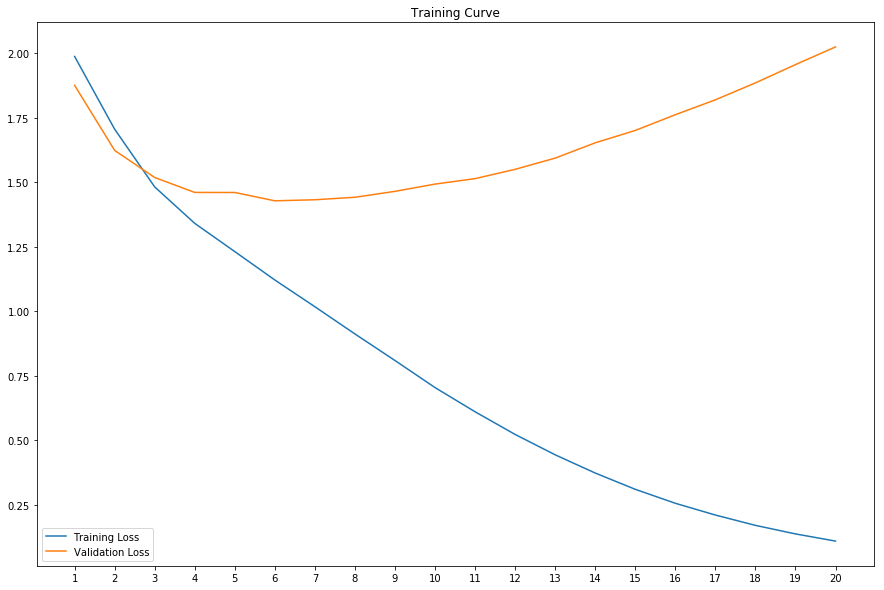

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(loss_train)+1), loss_train, label="Training Loss")
plt.plot(range(1, len(loss_val)+1), loss_val, label="Validation Loss")
plt.xticks(range(1, len(loss_val)+1))
#plt.ylim(0,0.7)
plt.legend()
plt.title("Training Curve")
plt.show()

In [63]:
model = BagOfWords(len(id2token), emb_dim)
#lambda1 = lambda epoch: 1-0.1*epoch
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
loss_train = []
loss_val = []
acc_val = []
for epoch in range(6):
    #scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    loss_train.append(loss)
    val_loss, val_acc = acc(model, val_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                       epoch+1, num_epochs, loss, val_loss, val_acc))

Epoch: [1/20], Train Loss: 1.984321683645248, Val Loss: 1.8721805524826045, Val Acc: 0.3140000104904175
Epoch: [2/20], Train Loss: 1.7011786177754418, Val Loss: 1.6252579700946803, Val Acc: 0.39800000190734863
Epoch: [3/20], Train Loss: 1.4836363396048535, Val Loss: 1.5096246957778925, Val Acc: 0.43220001459121704
Epoch: [4/20], Train Loss: 1.3414069819450378, Val Loss: 1.4609384101629264, Val Acc: 0.44519999623298645
Epoch: [5/20], Train Loss: 1.2261995701491823, Val Loss: 1.4332348948717122, Val Acc: 0.4472000002861023
Epoch: [6/20], Train Loss: 1.1188027209043516, Val Loss: 1.4226779758930206, Val Acc: 0.4447999894618988


In [65]:
_, pred,true = do_eval(
    model = model,
    dataloader = test_loader,
    )
print("Test Accuracy: {}".format((torch.exp(pred).max(1)[1] == true).float().mean().item()))
print("Top 3 Test Accuracy: {}".format(((torch.exp(pred).max(1)[1] <= true+1) & (torch.exp(pred).max(1)[1] >= true-1)).float().mean().item()))

Test Accuracy: 0.44196000695228577
Top 3 Test Accuracy: 0.6912400126457214
